In [11]:
import numpy as np
import pandas as pd
import simpy 
import matplotlib.pyplot as plt
import mercury as mr
from ipywidgets import interact, interactive, fixed, interact_manual

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Simulation Warteschlangen bei N-gleichen Fahrscheinautomaten

In [12]:
# set Application parameters
# set Application parameters
app = mr.App(title="Simulation Pilot",
        description="Simulation Warteschlangen bei N-gleichen Fahrscheinautomaten und N Touch&Go Geräte",
        show_code=False,
        show_prompt=True,
        continuous_update=False,
        static_notebook=False,
        show_sidebar=True,
        full_screen=True,
        allow_download=True)

mercury.App

In [28]:
def RunSim(NUM_FSA,NUM_TG,P,FGZ_PRO_MIN,TICKET_PRO_MIN,TICKET_PRO_MIN_TG,SIM_TIME,NUM_RUNS,video_flag='N'):
   
    import numpy as np
    import pandas as pd
    import simpy 
    import matplotlib.pyplot as plt
    import itertools
    from IPython import display
    from ipywidgets import interactive
    import matplotlib.pyplot as plt
    from ipywidgets import interact, interactive, fixed, interact_manual
    import ipywidgets as widgets
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    from IPython.display import HTML
    import warnings

    
    def TicketVerkaufSim(NUM_FSA,NUM_TG,P,FGZ_PRO_MIN,TICKET_PRO_MIN,TICKET_PRO_MIN_TG,SIM_TIME):
            """A station has a limited number of Fahrscheinautomaten (``NUM_MACHINES``) to
        sellt eh tickets in parallel.

        Fahrgast has to request one of the machines. When they got one, they
        can start the buying processes and wait for it to finish (which
        is described by the Possion distribution as well)."""


            import random

            def generate_fg(FGZ_PRO_MIN):
                return np.random.exponential(1.0/FGZ_PRO_MIN) # 10 customer per minute 
            #poisson_random_measure


            def assign_fsa(TICKET_PRO_MIN):
                return np.random.exponential(1.0/TICKET_PRO_MIN) # serve 2 customer per minute 


            def assign_tag(P):
                return np.random.choice(2, 1, p=[1-P, P])[0]


            #waiting time        
            wait_t={}       
            queues = []
            arr_t=[]    
            fg_ankommen={}
            service_t={}
            start_t={}
            choices={}
            fg_beended={}

            def fg(env,fg, resourcen):
                        t_arrival=env.now
                        fg_ankommen[fg]=t_arrival
                        QlengthFSA = {i:NoInSystem(resourcen[i]) for i in range(NUM_FSA)}
                        QlengthTG = {i:NoInSystem(resourcen[i]) for i in range(NUM_FSA,NUM_FSA+NUM_TG)}

                        queues.append({q:len(resourcen[q].put_queue) for q in range(len(resourcen))})
                        if NUM_TG==0:
                            TouchandGo=assign_tag(0)
                        else:
                            TouchandGo=assign_tag(P)
                        if NUM_TG==0 or TouchandGo==0:
                            choice=[k for k,v in sorted(QlengthFSA.items(), key=lambda a:a[1])][0]
                        else:
                            choice=[k for k,v in sorted(QlengthTG.items(), key=lambda a:a[1])][0]


                        choices[fg]=(choice)

                        with resourcen[choice].request() as request:              
                            yield request
                            t_service=env.now
                            start_t[fg]=(t_service)

                            wait_t[fg]=(t_service-t_arrival)

                            if NUM_TG==0 or TouchandGo==0:
                                yield env.timeout(assign_fsa(TICKET_PRO_MIN))
                            else:
                                yield env.timeout(assign_fsa(TICKET_PRO_MIN_TG))
                            queues.append({i: len(resourcen[i].put_queue) for i in range(len(resourcen))})

                            t_depart=env.now
                            service_t[fg]=(t_depart-t_service)

                            fg_beended[fg]=fg


            def fsa_run(env):
                i=0
                while True:
                    i+=1
                    yield env.timeout(generate_fg(FGZ_PRO_MIN))
                    env.process(fg(env,i, resourcen))

            def NoInSystem(f):
                """Total number of customers in the resource R"""
                return max([0, len(f.put_queue) + len(f.users)])



            ###Simulation part

            #np.random.seed(RANDOM_SEED) 
            np.random.seed() 

            env=simpy.Environment()
            #generate resources
            resourcen={i: simpy.Resource(env) for i in range(NUM_FSA+NUM_TG)}

            #run
            env.process(fsa_run(env))
            env.run(until=SIM_TIME)


            return wait_t, queues , arr_t, fg_ankommen,service_t,start_t, choices, fg_beended
        
    def create_output(fg_ankommen,start_t,choices,service_t,wait_t,fg_beended,SIM_TIME,NUM_FSA,NUM_TG):
        def dfconverter(dict,column,i):
            temp=pd.DataFrame(dict, index=[0]).T.reset_index()
            temp.columns=['fg',column]
            dictlist[i]=temp


        listCol=['arr_t','start_t','fsa','service_t','wait_t','fg_beended']
        listDict=[fg_ankommen,start_t,choices,service_t,wait_t,fg_beended]

        dictlist={}
        for i,x in enumerate(listDict):
            dfconverter(x,listCol[i],i)  
            
        df=dictlist[0].merge(dictlist[1], how='left',on='fg').merge(dictlist[2], how='left',on='fg').merge(dictlist[3], how='left',on='fg').merge(dictlist[4], how='left',on='fg').merge(dictlist[5], how='left',on='fg').sort_values(by='fg')
        ## fg noch in schlange:
        fg_ohne_t=len(df[df['wait_t'].isna()])

        if fg_ohne_t>0:
            ratio_fg_sch=len(df[df['wait_t'].isna()])/len(df)*100
        else:
            ratio_fg_sch=0

        df['ratio_fg_sch']=ratio_fg_sch
        df['fg_ohne_t']=fg_ohne_t

        df['wait_t_cl']=np.where(df['wait_t'].isna(),SIM_TIME-df['arr_t'],df['wait_t']) 
        df['start_t_cl']=np.where(((df['service_t'].isna()) & (~df['service_t'].isna())),SIM_TIME-df['start_t'],df['start_t']) 

        #df['wait_t']=df.start_t-df.arr_t
        for i in range(NUM_FSA+NUM_TG):
            df['start_t_'+str(i)]=np.where(df['fsa']==i,df['start_t_cl'],0)
            df['service_t_'+str(i)]=np.where(df['fsa']==i,df['service_t'],0) 
        df['wait_mean_sr']=df['wait_t'].mean()
        return df
    
    
    def mc_sim(NUM_FSA,NUM_TG,P,FGZ_PRO_MIN,TICKET_PRO_MIN,TICKET_PRO_MIN_TG,SIM_TIME,NUM_RUNS=100):
        output_sim={}
        queues_dict={}
        for i in range(0,NUM_RUNS):
            wait_t, queues , arr_t, fg_ankommen,service_t,start_t, choices, fg_beended=TicketVerkaufSim(NUM_FSA,NUM_TG,P,FGZ_PRO_MIN,TICKET_PRO_MIN,TICKET_PRO_MIN_TG,SIM_TIME)
            output_sim[i]=create_output(fg_ankommen,start_t,choices,service_t,wait_t,fg_beended,SIM_TIME,NUM_FSA,NUM_TG)
            queues_dict[i]=queues
        return output_sim,queues_dict

    def bericht(df_output,NUM_FSA,NUM_TG,P,FGZ_PRO_MIN,TICKET_PRO_MIN,TICKET_PRO_MIN_TG,SIM_TIME):
        print('Anzahl FG pro Min:' + str(FGZ_PRO_MIN))
        print('Anteil der FG fuer T&G:'+ "{:.0%}".format(P))

        print('Anzahl FSA:'+ str(NUM_FSA))
        print('Anzahl T&G:'+ str(NUM_TG))

        print('Anzahl Tickets pro Minute bei FSA:'+ str(TICKET_PRO_MIN))
        print('Anzahl Tickets pro Minute bei FSA:'+ str(TICKET_PRO_MIN_TG))


        print('Anzahl FG ohne Ticket nach '+ str(SIM_TIME) + ' Minuten:' + str(np.ceil(df_output.fg_ohne_t.mean()))+ ' ('+ format(df_output.ratio_fg_sch.mean(),".2f")+'%)')

        print('Druchnitliche Wartezeit in Minuten: '+ format(df_output['wait_t_cl'].mean(),".2f"))
        
    
    def plots(df_output,NUM_FSA,NUM_TG,NUM_RUNS):  

        import seaborn as sns

        sns.set_style("whitegrid")

        color=['orange','blue', 'green','yellow','red','brown','olive','purple','cyan','grey','pink']


        fig2, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
        plt.grid()

        h=axes[0].hist(df_output.wait_t_cl, bins=20, rwidth=0.9,color='#b0dcf7')
        axes[0].axvline(np.mean(df_output.wait_t_cl), color='red', label='Mean')
        axes[0].text(np.mean(df_output.wait_t_cl)+0.05,0,'Mean '+format((np.mean(df_output.wait_t_cl)), ".2f") ,rotation=90,color='red')
        axes[0].set_xlabel('Wartezeit[min]')
        axes[0].set_ylabel('Anzahl FG nach '+ str(NUM_RUNS) + ' Simulationen')
        warnings.filterwarnings("ignore", category=DeprecationWarning) 

        k=sns.distplot(df_output.wait_t_cl, ax=axes[1],color='#b0dcf7')
        axes[1].axvline(np.mean(df_output.wait_t_cl), color='red', label='Mean')
        axes[1].text(np.mean(df_output.wait_t_cl)+0.05,0,'Mean '+format((np.mean(df_output.wait_t_cl)), ".2f") ,rotation=90,color='red')
        axes[1].set_xlabel('Wartezeit[min]')
        axes[1].set_ylabel('Wahrscheinlichkeitdicht')

        ### Average Queue Time


        fig = plt.figure( figsize=(25,15))
        temp=df_output[df_output['sim_nr']==0]
        plt.barh(
            y=temp.fg,
            left=temp.arr_t,
            width=temp.wait_t_cl,
            alpha=1.0,
            color="gainsboro", label='Wartezeit')
        for i in range(NUM_FSA+NUM_TG):
            if i<NUM_FSA:
                label='Zeit beim FSA '+str(i+1)
            else:
                label='Zeit beim T&G '+str(i+1)
            plt.barh(
                y=temp.fg,
                left=temp['start_t_'+str(i)],
                width=temp['service_t_'+str(i)],
                alpha=1.0,
                color=color[i], label=label)

        plt.legend()
        # Set common labels
        plt.xlabel('Zeit[min]')
        plt.ylabel('FG Nummer')
        #axes[0].yticks(df.fg.unique().tolist())
        plt.show()
        plt.clf()
        
    def Video(queues_dict,df_output,NUM_FSA,NUM_TG,video_flag):
            ### Queues
            color=['orange','blue', 'green','yellow','red','brown','olive','purple','cyan','grey','pink']

            q = pd.DataFrame(queues_dict[0])
            temp=df_output[df_output['sim_nr']==0]

            if video_flag=='Y':
                %matplotlib notebook
                %matplotlib inline

                #plt.ioff()
                # animation function 
                numbers = list(itertools.chain(range(0, len(temp))))

                x=[]
                y={}
                for j in range(NUM_FSA+NUM_TG):
                    y[j]=[]
                fig3, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
                legend_list=[]
                def animate(i):

                    x.append(numbers[i])
                    for j in range(NUM_FSA+NUM_TG):
                        y[j].append((q[j][i]))
                        axes.plot(x, y[j], color=color[j])
                        if j<NUM_FSA:
                            legend_list.append('FSA'+str(j+1))
                        else:
                            legend_list.append('T&G'+str(j+1))

                    axes.legend(set(legend_list))

                plt.title("Warteschlangenaufbau")
                plt.xlabel('FG')
                plt.ylabel('Anzahl FG in der Schlange bei FSA/T&G')
                # call the animator	 
                anim = animation.FuncAnimation(fig3, animate, frames=len(temp), interval=800, repeat=False)
                video = anim.to_html5_video()
                html = display.HTML(video)
                display.display(html)

                plt.close()
            else:
                
                legend_list=[]
                pd.DataFrame(q).plot(figsize=(20, 5))
                
                for j in range(NUM_FSA+NUM_TG):
                    if j<NUM_FSA:
                        legend_list.append('FSA'+str(j+1))
                    else:
                        legend_list.append('T&G'+str(j+1))                    
                plt.legend(set(legend_list))

                plt.title("Warteschlangenaufbau")
                plt.xlabel('FG')
                plt.ylabel('Anzahl FG in der Schlange bei FSA/T&G')
                plt.show()
            
            

    
    output_sim,queues_dict=mc_sim(NUM_FSA,NUM_TG,P,FGZ_PRO_MIN,TICKET_PRO_MIN,TICKET_PRO_MIN_TG,SIM_TIME)
    
    df_output=pd.concat(output_sim).reset_index().drop('level_1', axis=1).rename(columns={'level_0':'sim_nr'})
        
    bericht(df_output,NUM_FSA,NUM_TG,P,FGZ_PRO_MIN,TICKET_PRO_MIN,TICKET_PRO_MIN_TG,SIM_TIME) 
    warnings.simplefilter(action='ignore', category=FutureWarning)

    plots(df_output,NUM_FSA,NUM_TG,NUM_RUNS)
    Video(queues_dict,df_output,NUM_FSA,NUM_TG,video_flag='N')


In [29]:
NUM_FSA = mr.Slider(value=3, min=1, max=6, label="Anzahl FSA", step=1)
NUM_TG = mr.Slider(value=3, min=1, max=6, label="Anzahl T&G Geräte", step=1)

FGZ_PRO_MIN= mr.Slider(value=15, min=1, max=45, label="Anzahl FG pro Minute", step=0.2)
P= mr.Slider(value=0.8, min=0.05, max=1, label="Anteil FG mit Einzeltickets - T&G Kunden", step=0.05)

SIM_TIME= mr.Slider(value=5, min=2, max=15, label="Zeitraum", step=1)
TICKET_PRO_MIN=mr.Slider(value=3, min=1, max=30, label="Anzahl Tickets pro Minute bei FSA", step=1)
TICKET_PRO_MIN_TG=mr.Slider(value=3, min=1, max=30, label="Anzahl Tickets pro Minute bei T&G", step=1)

NUM_RUNS=mr.Slider(value=10, min=1, max=10000, label="MC Runs", step=1)

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

In [30]:
#video_flag = mr.Select(value="N", choices=['N','Y'], label="Video")


Anzahl FG pro Min:15.0
Anteil der FG fuer T&G:80%
Anzahl FSA:3
Anzahl T&G:3
Anzahl Tickets pro Minute bei FSA:3
Anzahl Tickets pro Minute bei FSA:3
Anzahl FG ohne Ticket nach 5 Minuten:16.0 (20.76%)
Druchnitliche Wartezeit in Minuten: 0.51


C:\Users\ndrmon\AppData\Local\Temp/ipykernel_30772/2346419146.py:201: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  k=sns.distplot(df_output.wait_t_cl, ax=axes[1],color='#b0dcf7')


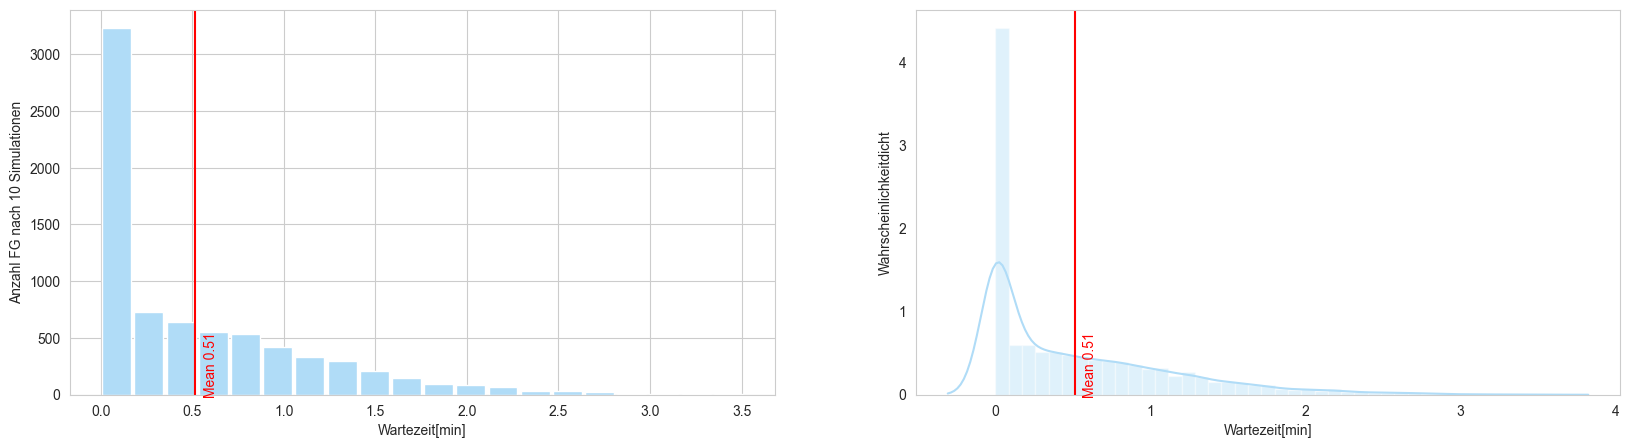

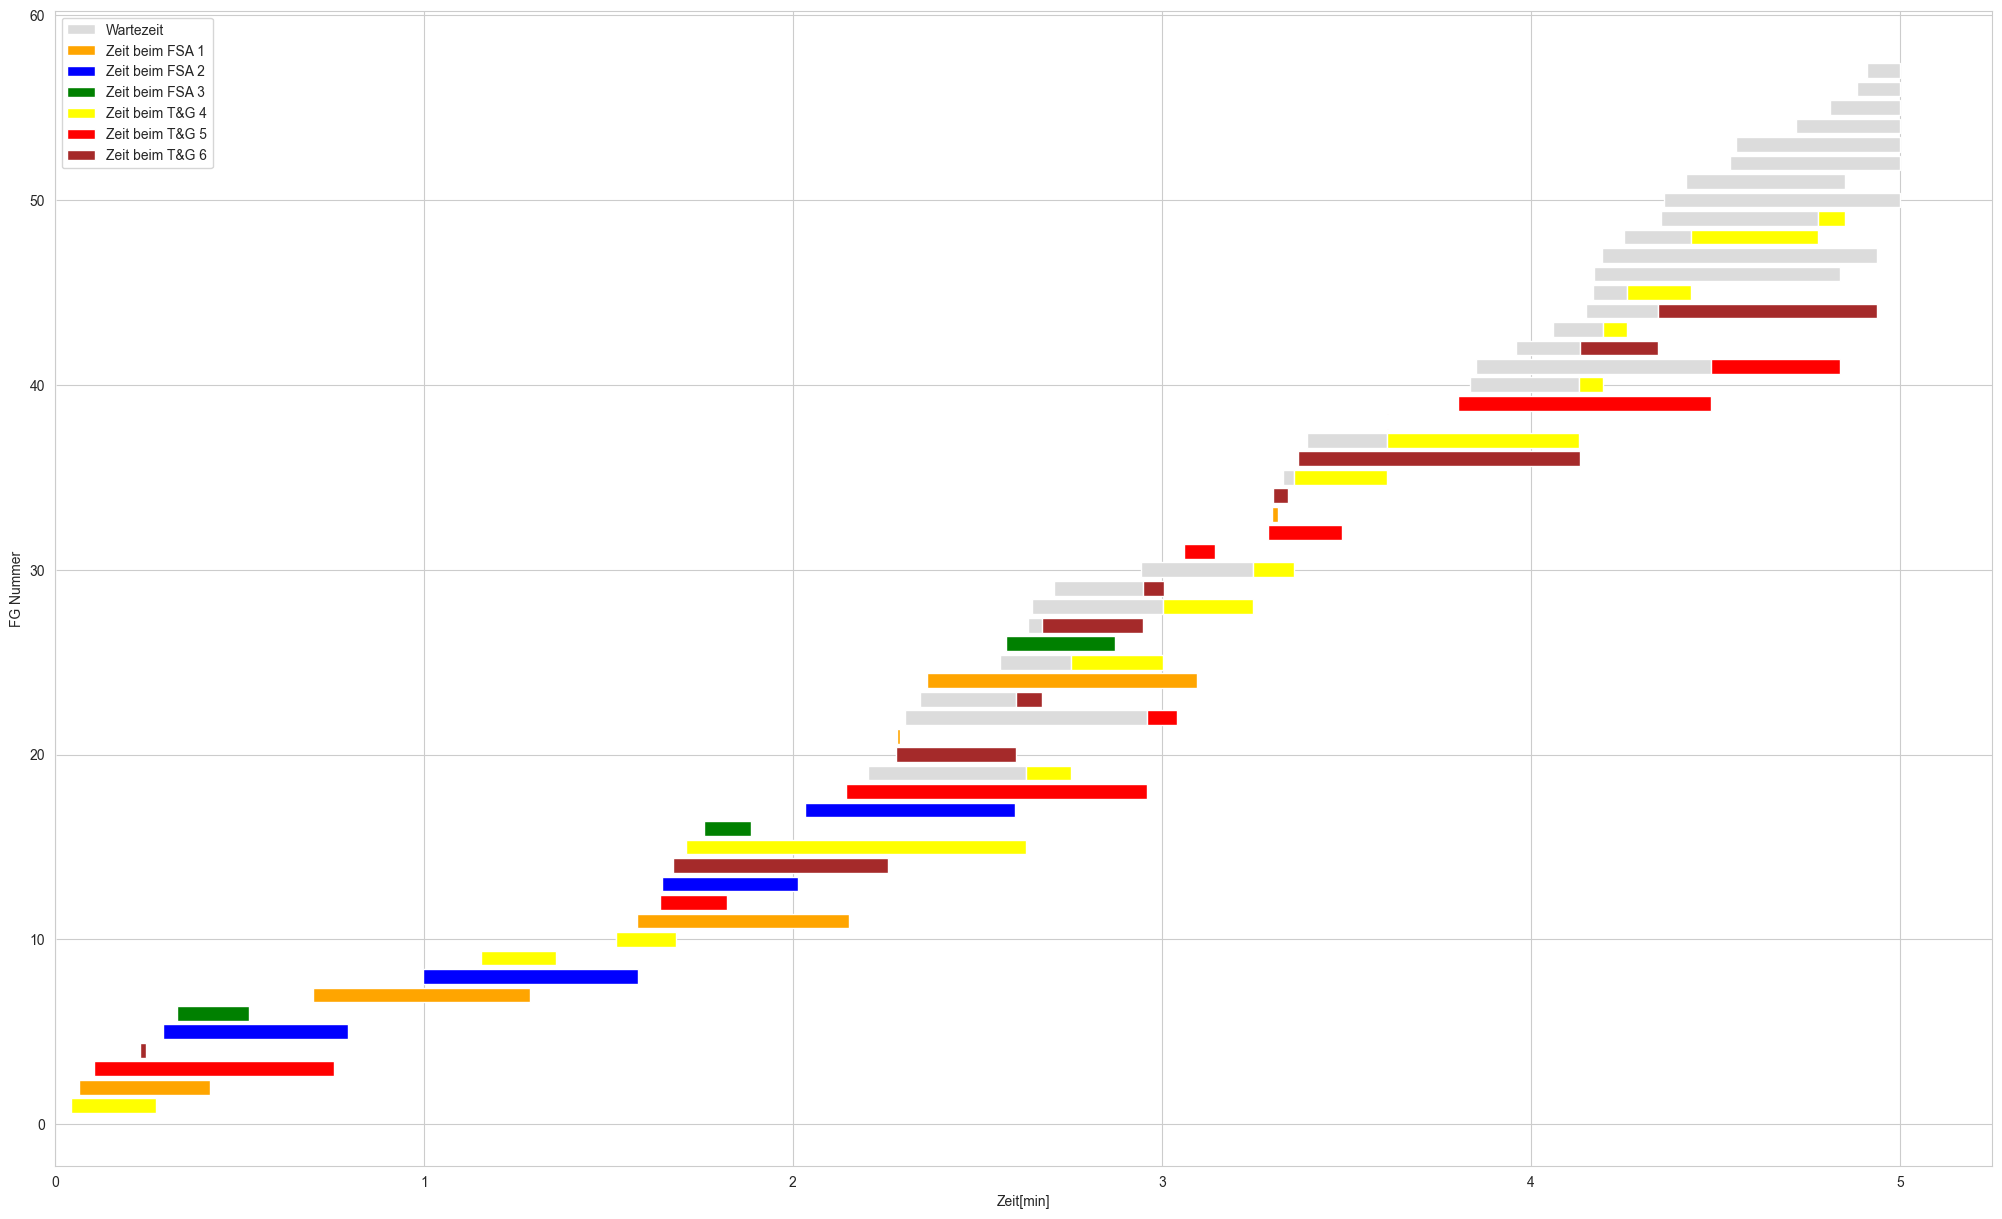

<Figure size 640x480 with 0 Axes>

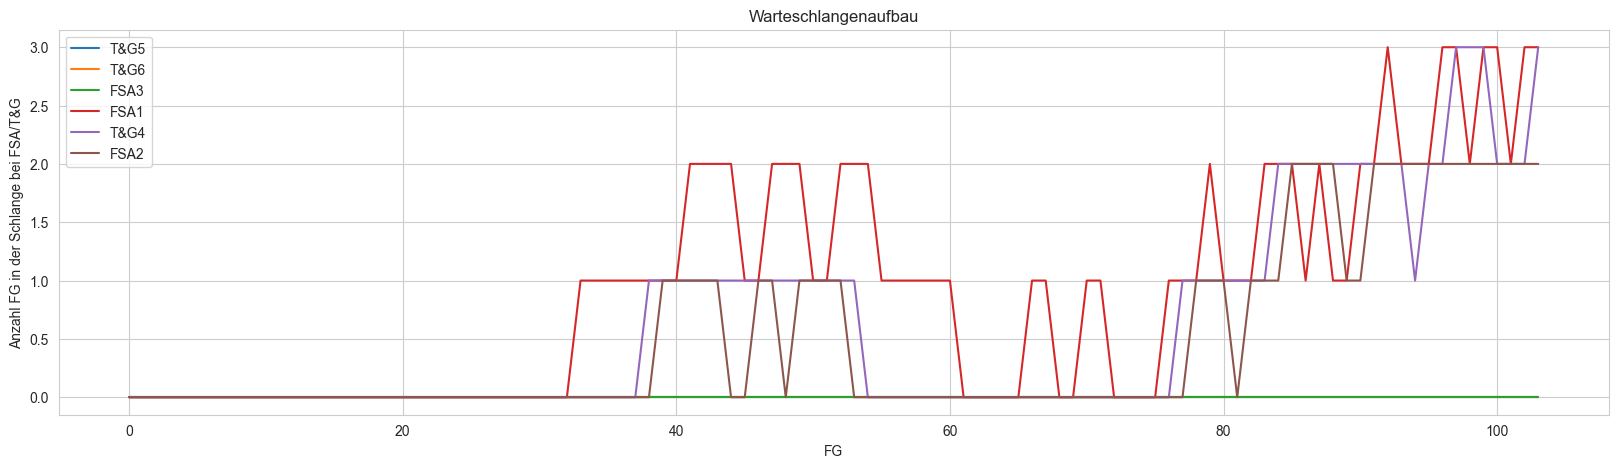

In [31]:
%matplotlib notebook
%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

RunSim(NUM_FSA.value,NUM_TG.value,P.value,FGZ_PRO_MIN.value,TICKET_PRO_MIN.value,TICKET_PRO_MIN_TG.value,SIM_TIME.value,NUM_RUNS.value,video_flag='N')
